<a href="https://colab.research.google.com/github/weiSENshu/NLP/blob/main/token_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#在NER任务上微调BERT模型


In [1]:
!pip install datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00


##准备数据

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
raw_datasets  #检查数据项

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [5]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [6]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

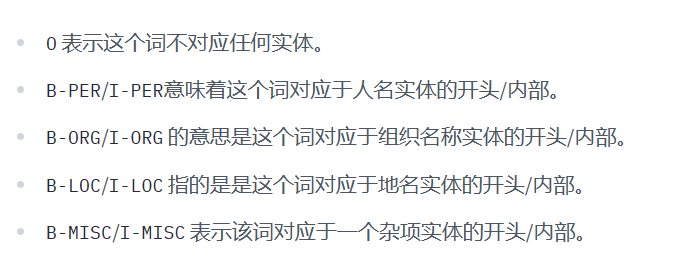

In [7]:
#ner解码
words = raw_datasets["train"][4]["tokens"]
labels = raw_datasets["train"][4]["ner_tags"]

line1 = ""
line2 = ""
for word, label in zip(words, labels):
  full_label = label_names[label]
  max_length = max(len(word), len(full_label))
  line1 += word +" " * (max_length - len(word) + 1) #为了两行上下单词对齐
  line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)


Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer . 
B-LOC   O  O              O  O   B-ORG    I-ORG O  O          O         B-PER  I-PER     O    O  O         O         O      O   O         O    O         O     O    B-LOC   O     O   O          O      O   O       O 


In [8]:

raw_datasets["train"][0]["pos_tags"]

[22, 42, 16, 21, 35, 37, 16, 21, 7]

In [9]:
pos_feature = raw_datasets["train"].features["pos_tags"]
pos_feature

Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None)

In [10]:
label_names = pos_feature.feature.names
label_names

['"',
 "''",
 '#',
 '$',
 '(',
 ')',
 ',',
 '.',
 ':',
 '``',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'NN|SYM',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'SYM',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

In [11]:
#pos解码
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["pos_tags"]
line1= ""
line2 = ""
for word, label in zip(words, labels):
  full_label = label_names[label]
  max_length = max(len(word), len(full_label))
  line1 += word + " "*(max_length -len(word) +1)
  line2 += full_label +" " *(max_length -len(full_label) +1)

print(line1)
print(line2)

EU  rejects German call to boycott British lamb . 
NNP VBZ     JJ     NN   TO VB      JJ      NN   . 


In [12]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [13]:
raw_datasets["train"][0]["chunk_tags"]

[11, 21, 11, 12, 21, 22, 11, 12, 0]

In [14]:
label_names = raw_datasets["train"].features["chunk_tags"].feature.names
label_names

['O',
 'B-ADJP',
 'I-ADJP',
 'B-ADVP',
 'I-ADVP',
 'B-CONJP',
 'I-CONJP',
 'B-INTJ',
 'I-INTJ',
 'B-LST',
 'I-LST',
 'B-NP',
 'I-NP',
 'B-PP',
 'I-PP',
 'B-PRT',
 'I-PRT',
 'B-SBAR',
 'I-SBAR',
 'B-UCP',
 'I-UCP',
 'B-VP',
 'I-VP']

In [15]:
#解码Chunk
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["chunk_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
  full_label = label_names[label]
  max_length = max(len(word), len(full_label))
  line1 += word +" " * (max_length - len(word) +1)
  line2 += full_label + " " * (max_length -len(full_label) +1)

print(line1)
print(line2)


EU   rejects German call to   boycott British lamb . 
B-NP B-VP    B-NP   I-NP B-VP I-VP    B-NP    I-NP O 


##处理数据

In [16]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [17]:
tokenizer.is_fast

True

In [18]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words = True)
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [19]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [20]:
def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word = None
  for word_id in word_ids:
    if word_id != current_word:
      current_word = word_id
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)
    elif word_id is None:
      #特殊标签
      new_labels.append(-100)
    else:
      #当前word_id和前一个word_id相同
      label = labels[word_id]
      #如果标签是B-则替换成I-
      if label % 2 == 1:
        label += 1
      new_labels.append(label)
  return new_labels




In [21]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


###批处理数据

In [22]:
#对示例进行标记，并在标签上应用align_labels_with_tokens()
def tokenize_and_align_labels(examples):
  
  tokenized_inputs = tokenizer(
      examples["tokens"], truncation=True, is_split_into_words= True
  )
  all_labels = examples["ner_tags"]
  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))
  tokenized_inputs["labels"] = new_labels
  return tokenized_inputs

In [23]:
# def tokenize_and_align_labels(examples):
#   tokenized_inputs = tokenizer(
#       examples["tokens"], truncation=True, is_split_into_words=True
#   )

#   all_labels = examples["ner_tags"]
#   new_labels = []
#   for i, labels in enumerate(all_labels):
#     word_ids = tokenized_inputs.word_ids[i],
#     new_labels.append(align_labels_with_tokens(labels, word_ids))
#   tokenized_inputs["labels"] = new_labels
#   return tokenized_inputs

In [24]:
#使用Dataset.map()方法，进行批处理，将tokenize_and_align_labels应用到所有数据集中
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched = True,
    #删除原始列名
    remove_columns = raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [25]:
# tokenized_datasets = raw_datasets.map(
#     tokenize_and_align_labels,
#     batched = True,
#     #删除原始列名
#     remove_columns = raw_datasets["train"].columns_names,
# )

##使用TrainerAPI微调模型

###数据排序